# T81-558: Applications of Deep Neural Networks
**Class 9: Regularization: L1, L2 and Dropout**
* Instructor: [Jeff Heaton](https://sites.wustl.edu/jeffheaton/), School of Engineering and Applied Science, [Washington University in St. Louis](https://engineering.wustl.edu/Programs/Pages/default.aspx)
* For more information visit the [class website](https://sites.wustl.edu/jeffheaton/t81-558/).

# Regularization

Regularization is a technique that reduces overfitting, which occurs when neural networks attempt to memorize training data, rather than learn from it.  Humans are capable of overfitting as well.  Before we examine the ways that a machine accidentally overfits, we will first explore how humans can suffer from it.

Human programmers often take certification exams to show their competence in a given programming language.  To help prepare for these exams, the test makers often make practice exams available.  Consider a programmer who enters a loop of taking the practice exam, studying more, and then taking the practice exam again.  At some point, the programmer has memorized much of the practice exam, rather than learning the techniques necessary to figure out the individual questions.  The programmer has now overfit to the practice exam.  When this programmer takes the real exam, his actual score will likely be lower than what he earned on the practice exam.
 
 A computer can overfit as well.  Although a neural network received a high score on its training data, this result does not mean that the same neural network will score high on data that was not inside the training set.  Regularization is one of the techniques that can prevent overfitting. A number of different regularization techniques exist.  Most work by analyzing and potentially modifying the weights of a neural network as it trains.  


# Helpful Functions

We've used these functions before, they are just to help process the data.

In [1]:
# Collection of Helpful Functions for Class
# This is a collection of helpful functions that I will introduce during this class.
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df,name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name,x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)

# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df,name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_

# Encode a numeric column as zscores
def encode_numeric_zscore(df,name,mean=None,sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name]-mean)/sd

# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)

# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df,target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)

    # find out the type of the target column.  Is it really this hard? :(
    target_type = df[target].dtypes
    target_type = target_type[0] if hasattr(target_type, '__iter__') else target_type
    print(target_type)
    
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        return df.as_matrix(result).astype(np.float32),df.as_matrix([target]).astype(np.int32)
    else:
        # Regression
        return df.as_matrix(result).astype(np.float32),df.as_matrix([target]).astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

# Regression chart, we will see more of this chart in the next class.
def chart_regression(pred,y):
    t = pd.DataFrame({'pred' : pred.flatten(), 'y' : y_test.flatten()})
    t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

/usr/local/lib/python3.4/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/usr/local/lib/python3.4/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
# Simple function to evaluate the coefficients of a regression
%matplotlib inline    
from IPython.display import display, HTML    

def report_coef(names,coef,intercept):
    r = pd.DataFrame( { 'coef': coef, 'positive': coef>=0  }, index = names )
    r = r.sort(['coef'])
    display(r)
    print("Intercept: {}".format(intercept))
    r['coef'].plot(kind='barh', color=r['positive'].map({True: 'b', False: 'r'}))


# Setup Data

We are going to look at linear regression to see how L1 and L2 regularization work.  The following code sets up the auto-mpg data for this purpose.

In [4]:
from sklearn.linear_model import LassoCV
import pandas as pd
import os
import numpy as np
from sklearn import metrics
from scipy.stats import zscore
from sklearn.cross_validation import train_test_split 

path = "./data/"

filename_read = os.path.join(path,"auto-mpg.csv")
df = pd.read_csv(filename_read,na_values=['NA','?'])

# create feature vector
missing_median(df, 'horsepower')
df.drop('name',1,inplace=True)
# Do not need zscore standardization for linear regression
#encode_numeric_zscore(df, 'horsepower')
#encode_numeric_zscore(df, 'weight')
#encode_numeric_zscore(df, 'cylinders')
#encode_numeric_zscore(df, 'displacement')
#encode_numeric_zscore(df, 'acceleration')
encode_text_dummy(df, 'origin')

# Encode to a 2D matrix for training
x,y = to_xy(df,'mpg')

# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(    
    x, y, test_size=0.25, random_state=45) 
        

float64


# Linear Regression

To understand L1/L2 regularization, it is good to start with linear regression.  L1/L2 were first introduced for linear regression.  They can also be used for neural networks.  To fully understand L1/L2 we will begin with how they are used with linear regression.

The following code uses linear regression to fit the auto-mpg data set.  The RMSE reported will not be as good as a neural network.

Final score (RMSE): 2.937156826966663


/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:7: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,coef,positive
origin-1,-1.448374,False
cylinders,-0.416545,False
horsepower,-0.007785,False
weight,-0.007473,False
displacement,0.024456,True
acceleration,0.138122,True
origin-3,0.629809,True
year,0.801274,True
origin-2,0.818566,True


Intercept: [-18.25751739]


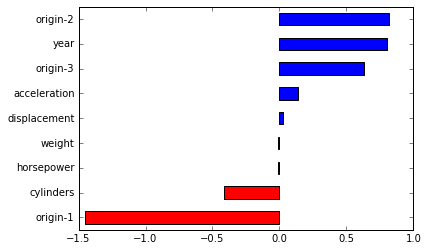

In [5]:
import sklearn

# Create linear regression
regressor = sklearn.linear_model.LinearRegression()

# Fit/train linear regression
regressor.fit(x_train,y_train)
# Predict
pred = regressor.predict(x_test)

# Measure RMSE error.  RMSE is common for regression.
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Final score (RMSE): {}".format(score))

names = list(df.columns.values)
names.remove("mpg")
report_coef(
  names,
  regressor.coef_[0,:],
  regressor.intercept_)


# L1 (Lasso) Regularization

L1 Regularization, also called LASSO (Least Absolute Shrinkage and Selection Operator) is should be used to create sparsity in the neural network. In other words, the L1 algorithm will push many weight connections to near 0.  When a weight is near 0, the program drops it from the network.  Dropping weighted connections will create a sparse neural network.

Feature selection is a useful byproduct of sparse neural networks. Features are the values that the training set provides to the input neurons.  Once all the weights of an input neuron reach 0, the neural network training determines that the feature is unnecessary.  If your data set has a large number of input features that may not be needed, L1 regularization can help the neural network detect and ignore unnecessary features.

L1 is implemented by adding the following error to the objective to minimize:

$$ E_1 = \alpha \sum_w{ |w| } $$

The following code demonstrates lasso regression.  Notice the effect of the coefficients compared to the previous section that used linear regression.

Final score (RMSE): 3.0409059622587042


/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:7: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,coef,positive
origin-1,-1.264473,False
weight,-0.007458,False
horsepower,-0.002797,False
cylinders,-0.000000,True
origin-2,0.000000,True
origin-3,0.000000,True
displacement,0.013005,True
acceleration,0.113760,True
year,0.787195,True


Intercept: [-17.27126679]


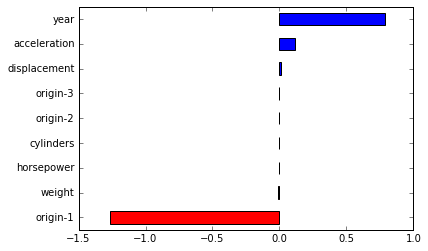

In [10]:
import sklearn
from sklearn.linear_model import Lasso

# Create linear regression
regressor = Lasso(random_state=0,alpha=0.1)

# Fit/train LASSO
regressor.fit(x_train,y_train)
# Predict
pred = regressor.predict(x_test)

# Measure RMSE error.  RMSE is common for regression.
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Final score (RMSE): {}".format(score))

names = list(df.columns.values)
names.remove("mpg")
report_coef(
  names,
  regressor.coef_,
  regressor.intercept_)


/usr/local/lib/python3.4/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)
/usr/local/lib/python3.4/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)
/usr/local/lib/python3.4/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)
/usr/local/lib/python3.4/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)
/usr/local/lib/python3.4/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase th

(1e-08, 100000000.0)

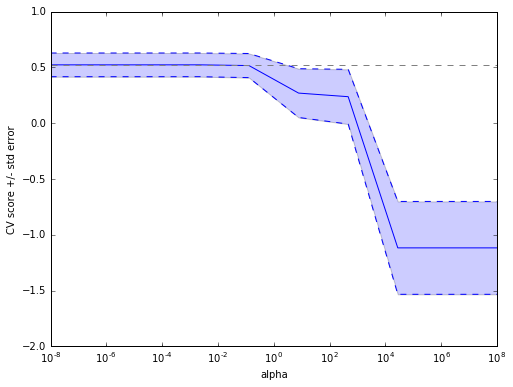

In [144]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.cross_validation import KFold
from sklearn.cross_validation import cross_val_score

lasso = Lasso(random_state=42)
alphas = np.logspace(-8, 8, 10)

scores = list()
scores_std = list()

n_folds = 3

for alpha in alphas:
    lasso.alpha = alpha
    this_scores = cross_val_score(lasso, x, y, cv=n_folds, n_jobs=1)
    scores.append(np.mean(this_scores))
    scores_std.append(np.std(this_scores))

scores, scores_std = np.array(scores), np.array(scores_std)

plt.figure().set_size_inches(8, 6)
plt.semilogx(alphas, scores)

# plot error lines showing +/- std. errors of the scores
std_error = scores_std / np.sqrt(n_folds)

plt.semilogx(alphas, scores + std_error, 'b--')
plt.semilogx(alphas, scores - std_error, 'b--')

# alpha=0.2 controls the translucency of the fill color
plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2)

plt.ylabel('CV score +/- std error')
plt.xlabel('alpha')
plt.axhline(np.max(scores), linestyle='--', color='.5')
plt.xlim([alphas[0], alphas[-1]])

# L2 (Ridge) Regularization

You should use Tikhonov/Ridge/L2 regularization when you are less concerned about creating a space network and are more concerned about low weight values.  The lower weight values will typically lead to less overfitting. 

$$ E_1 = \alpha \sum_w{ w^2 } $$

Like the L1 algorithm, the $\alpha$ value determines how important the L2 objective is compared to the neural network’s error.  Typical L2 values are below 0.1 (10%).  The main calculation performed by L2 is the summing of the squares of all of the weights.  The bias values are not summed.

The following code uses L2 with linear regression (Ridge regression):

Final score (RMSE): 2.9413154427467063


/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:7: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,coef,positive
origin-1,-1.420925,False
cylinders,-0.409651,False
horsepower,-0.007524,False
weight,-0.007473,False
displacement,0.024128,True
acceleration,0.137985,True
origin-3,0.619104,True
year,0.800769,True
origin-2,0.801821,True


Intercept: [-18.23057194]


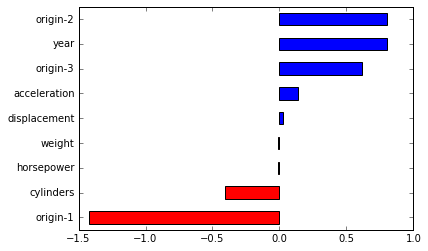

In [12]:
import sklearn
from sklearn.linear_model import Ridge

# Create linear regression
regressor = Ridge(alpha=1)

# Fit/train Ridge
regressor.fit(x_train,y_train)
# Predict
pred = regressor.predict(x_test)

# Measure RMSE error.  RMSE is common for regression.
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Final score (RMSE): {}".format(score))

names = list(df.columns.values)
names.remove("mpg")
report_coef(
  names,
  regressor.coef_[0,:],
  regressor.intercept_)


Final score (RMSE): 2.9371563550902593


/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:8: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
/usr/local/lib/python3.4/dist-packages/sklearn/linear_model/coordinate_descent.py:454: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  positive)
/usr/local/lib/python3.4/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)
/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:7: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,coef,positive
origin-1,-2.148458,False
cylinders,-0.416546,False
origin-3,-0.070275,False
horsepower,-0.007785,False
weight,-0.007473,False
displacement,0.024456,True
origin-2,0.118481,True
acceleration,0.138122,True
year,0.801274,True


Intercept: [-17.55741926]


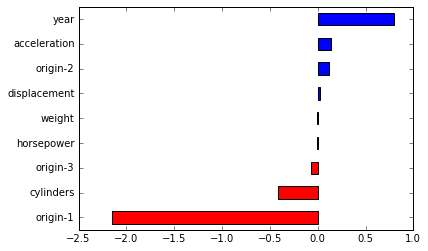

In [134]:
import sklearn
from sklearn.linear_model import ElasticNet

# Create linear regression
regressor = ElasticNet(alpha=0.0, l1_ratio=0.1)

# Fit/train LASSO
regressor.fit(x_train,y_train)
# Predict
pred = regressor.predict(x_test)

# Measure RMSE error.  RMSE is common for regression.
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Final score (RMSE): {}".format(score))

names = list(df.columns.values)
names.remove("mpg")
report_coef(
  names,
  regressor.coef_,
  regressor.intercept_)

# TensorFlow and L1/L2

L1 and L2 regularization are two common regularization techniques that can reduce the effects of overfitting (Ng, 2004).  Both of these algorithms can either work with an objective function or as a part of the backpropagation algorithm.  In both cases the regularization algorithm is attached to the training algorithm by adding an additional objective.  

Both of these algorithms work by adding a weight penalty to the neural network training.  This penalty encourages the neural network to keep the weights to small values.  Both L1 and L2 calculate this penalty differently.  For gradient-descent-based algorithms, such as backpropagation, you can add this penalty calculation to the calculated gradients.  For objective-function-based training, such as simulated annealing, the penalty is negatively combined with the objective score.

Both L1 and L2 work differently in the way that they penalize the size of a weight.  L1 will force the weights into a pattern similar to a Gaussian distribution; the L2 will force the weights into a pattern similar to a Laplace distribution, as demonstrated the following:

![L1 vs L2](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/class_9_l1_l2.png "L1 vs L2")

As you can see, L1 algorithm is more tolerant of weights further from 0, whereas the L2 algorithm is less tolerant.  We will highlight other important differences between L1 and L2 in the following sections.  You also need to note that both L1 and L2 count their penalties based only on weights; they do not count penalties on bias values.

Tensor flow allows [l1/l2 to be directly added to your network](http://tensorlayer.readthedocs.io/en/stable/modules/cost.html).

Animation that shows how [dropout works](https://yusugomori.com/projects/deep-learning/dropout-relu)

In [20]:
########################################
# TensorFlow with L1/L2 for Regression
########################################
from sklearn import datasets, metrics
import tensorflow as tf
import os
import pandas as pd
from sklearn.cross_validation import train_test_split
import tensorflow.contrib.learn as skflow
import numpy as np

def dropout_model_regression(X, y):
    """This is DNN with 10, 20, 10 hidden layers, and dropout of 0.01 probability."""
    layers = skflow.ops.dnn(X, [10, 20, 10], regularize=
                            tf.contrib.layers.l2_regularizer(0.05))    
    return skflow.models.linear_regression(layers, y)

path = "./data/"

filename_read = os.path.join(path,"auto-mpg.csv")
df = pd.read_csv(filename_read,na_values=['NA','?'])

# create feature vector
missing_median(df, 'horsepower')
df.drop('name',1,inplace=True)
encode_numeric_zscore(df, 'horsepower')
encode_numeric_zscore(df, 'weight')
encode_numeric_zscore(df, 'cylinders')
encode_numeric_zscore(df, 'displacement')
encode_numeric_zscore(df, 'acceleration')
encode_text_dummy(df, 'origin')

# Encode to a 2D matrix for training
x,y = to_xy(df,'mpg')

# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.20, random_state=42)

# Create a custom model
regressor = skflow.TensorFlowEstimator(model_fn=dropout_model_regression, n_classes=0, steps=10000)

# Early stopping
early_stop = skflow.monitors.ValidationMonitor(x_test, y_test,
    early_stopping_rounds=200, print_steps=50)

# Fit/train neural network
regressor.fit(x_train, y_train, monitor=early_stop)

# Measure RMSE error.  RMSE is common for regression.
pred = regressor.predict(x_test)
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Final score (RMSE): {}".format(score))

float64


TypeError: dnn() got an unexpected keyword argument 'regularize'

# Dropout Regularization

Most neural network frameworks implement dropout as a separate layer.  Dropout layers function as a regular, densely connected neural network layer.  The only difference is that the dropout layers will periodically drop some of their neurons during training.  You can use dropout layers on regular feedforward neural networks. In fact, they can also become layers in convolutional LeNET-5 networks like we studied in class 8.

The usual hyper-parameters for a dropout layer are the following:
* Neuron Count
* Activation Function
* Dropout Probability

The neuron count and activation function hyper-parameters work exactly the same way as their corresponding parameters in the dense layer type mentioned previously. The neuron count simply specifies the number of neurons in the dropout layer.  The dropout probability indicates the likelihood of a neuron dropping out during the training iteration.  Just as it does for a dense layer, the program specifies an activation function for the dropout layer.

![Dropout Regularization](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/class_9_dropout.png "Dropout Regularization")

A certain percentage neurons we be masked during each training step.  All neurons return after training is complete.

In [25]:
############################################
# TensorFlow with Dropout for Classification
############################################
from sklearn import datasets, metrics
import os
import pandas as pd
from sklearn.cross_validation import train_test_split
import tensorflow.contrib.learn as skflow
import numpy as np

def dropout_model_classification(X, y):
    """This is DNN with 10, 20, 10 hidden layers, and dropout of 0.5 probability."""
    layers = skflow.ops.dnn(X, [10, 20, 10], dropout=0.1)
    return skflow.models.logistic_regression(layers, y)

path = "./data/"
    
filename = os.path.join(path,"iris.csv")    
df = pd.read_csv(filename,na_values=['NA','?'])

# Encode feature vector
encode_numeric_zscore(df,'petal_w')
encode_numeric_zscore(df,'petal_l')
encode_numeric_zscore(df,'sepal_w')
encode_numeric_zscore(df,'sepal_l')
species = encode_text_index(df,"species")
num_classes = len(species)

# Create x & y for training

# Create the x-side (feature vectors) of the training
x, y = to_xy(df,'species')
    
# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(    
    x, y, test_size=0.25, random_state=42) 
        
# Create a custom model
classifier = skflow.TensorFlowEstimator(model_fn=dropout_model_classification, n_classes=num_classes, steps=10000)

# Early stopping
early_stop = skflow.monitors.ValidationMonitor(x_test, y_test,
    early_stopping_rounds=200, print_steps=50, n_classes=num_classes)
    
# Fit/train neural network
classifier.fit(x_train, y_train, monitor=early_stop)

# Evaluate success using accuracy
pred = classifier.predict(x_test)
score = metrics.accuracy_score(y_test, pred)
print("Accuracy score: {}".format(score))

int64


/usr/local/lib/python3.4/dist-packages/tensorflow/contrib/learn/python/learn/io/data_feeder.py:281: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  out.itemset((i, self.y[sample]), 1.0)


Step #50, epoch #12, avg. train loss: 0.41878, avg. val loss: 0.33007
Step #100, epoch #25, avg. train loss: 0.19759, avg. val loss: 0.13913
Step #150, epoch #37, avg. train loss: 0.16370, avg. val loss: 0.09925
Step #200, epoch #50, avg. train loss: 0.13042, avg. val loss: 0.07665
Step #250, epoch #62, avg. train loss: 0.11948, avg. val loss: 0.06742
Step #300, epoch #75, avg. train loss: 0.10932, avg. val loss: 0.06868
Step #350, epoch #87, avg. train loss: 0.09808, avg. val loss: 0.05818
Step #400, epoch #100, avg. train loss: 0.09841, avg. val loss: 0.05867
Step #450, epoch #112, avg. train loss: 0.10703, avg. val loss: 0.05124
Step #500, epoch #125, avg. train loss: 0.09953, avg. val loss: 0.04126
Step #550, epoch #137, avg. train loss: 0.10049, avg. val loss: 0.04963
Step #600, epoch #150, avg. train loss: 0.08647, avg. val loss: 0.04703
Step #650, epoch #162, avg. train loss: 0.08072, avg. val loss: 0.04591
Accuracy score: 1.0


Stopping. Best step:
 step 462 with loss 0.009459641762077808


In [26]:
########################################
# TensorFlow with Dropout for Regression
########################################
from sklearn import datasets, metrics
import os
import pandas as pd
from sklearn.cross_validation import train_test_split
import tensorflow.contrib.learn as skflow
import numpy as np

def dropout_model_regression(X, y):
    """This is DNN with 10, 20, 10 hidden layers, and dropout of 0.01 probability."""
    layers = skflow.ops.dnn(X, [10, 20, 10], dropout=0.01)    
    return skflow.models.linear_regression(layers, y)

path = "./data/"

filename_read = os.path.join(path,"auto-mpg.csv")
df = pd.read_csv(filename_read,na_values=['NA','?'])

# create feature vector
missing_median(df, 'horsepower')
df.drop('name',1,inplace=True)
encode_numeric_zscore(df, 'horsepower')
encode_numeric_zscore(df, 'weight')
encode_numeric_zscore(df, 'cylinders')
encode_numeric_zscore(df, 'displacement')
encode_numeric_zscore(df, 'acceleration')
encode_text_dummy(df, 'origin')

# Encode to a 2D matrix for training
x,y = to_xy(df,'mpg')

# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.20, random_state=42)

# Create a custom model
regressor = skflow.TensorFlowEstimator(model_fn=dropout_model_regression, n_classes=0, steps=10000)

# Early stopping
early_stop = skflow.monitors.ValidationMonitor(x_test, y_test,
    early_stopping_rounds=200, print_steps=50)

# Fit/train neural network
regressor.fit(x_train, y_train, monitor=early_stop)

# Measure RMSE error.  RMSE is common for regression.
pred = regressor.predict(x_test)
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Final score (RMSE): {}".format(score))


float64
Step #50, epoch #5, avg. train loss: 31.52437, avg. val loss: 25.73745
Step #100, epoch #10, avg. train loss: 6.78861, avg. val loss: 6.60194
Step #150, epoch #15, avg. train loss: 4.31313, avg. val loss: 4.30436
Step #200, epoch #20, avg. train loss: 3.03822, avg. val loss: 3.35483
Step #250, epoch #25, avg. train loss: 2.72637, avg. val loss: 2.64239
Step #300, epoch #30, avg. train loss: 2.96839, avg. val loss: 2.76600
Step #350, epoch #35, avg. train loss: 2.41577, avg. val loss: 2.10936
Step #400, epoch #40, avg. train loss: 2.24474, avg. val loss: 2.07290
Step #450, epoch #45, avg. train loss: 1.86916, avg. val loss: 1.96377
Final score (RMSE): 0.7129486203193665


Stopping. Best step:
 step 263 with loss 0.33217647671699524


In [18]:
df2 = df[ df.year == 70]
df2['new_col'] = [x for x in range(len())]
df2
df2.to_csv('test.csv')

/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
